In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.spatial.distance
import scipy

import csv

In [2]:
GT = np.genfromtxt('ds0_Groundtruth.dat', skip_header = 3, skip_footer = 0, names = True, dtype = None, delimiter = ' ' , usecols = [0, 3, 5, 7])
Odom = np.genfromtxt('ds0_Odometry.dat', skip_header = 3, skip_footer = 0, names = True, dtype = None, delimiter = ' ' , usecols = [0,4,5])

In [3]:
start_time = GT[0][0]
for i in range(len(GT)):
    GT[i][0]-= start_time
for i in range(len(Odom)):
    Odom[i][0]-=start_time

In [4]:
j = 1
k = 1
align = []

for i in range (len(GT)):
    match = 0
    while (match == 0 and j < len(GT) and k < len(Odom)-1):
        if (GT[j][0] - Odom[k][0] > 0 and GT[j][0] - Odom[k+1][0]<= 0):
            align.append((GT[j], Odom[k]))
            j+=1
            match = 1
        else:
            k+=1

In [5]:
train_in = []
train_out = []

test_in = []
test_out = []

val_in = []
val_out = []

ind = np.linspace(0, len(align), 10000)
ind_count = 0

for i in range(len(align) - 2):
    
    dt_in = align[i+1][0][0] - align[i][0][0]
    
    x_in = align[i+1][0][1] - align[i][0][1]
    y_in = align[i+1][0][2] - align[i][0][2]
    theta_in = align[i+1][0][3] - align[i][0][3]
    
    v_in = align[i+1][1][1] - align[i][1][1]
    w_in = align[i+1][1][2] - align[i][1][2]

    dt_out = align[i+2][0][0] - align[i+1][0][0] # (t+1) - (t)
    
    x_out = align[i+2][0][1] - align[i+1][0][1]
    y_out = align[i+2][0][2] - align[i+1][0][2]
    theta_out = align[i+2][0][3] - align[i+1][0][3]
    
    if (i == int(ind[ind_count]) and ind_count%2 ==0):
        test_in.append([x_in/dt_in, y_in/dt_in, theta_in/dt_in, v_in/dt_out, w_in/dt_out])
        test_out.append([x_out/dt_out, y_out/dt_out, theta_out/dt_out])
        ind_count+=1
    elif (i == int(ind[ind_count]) and ind_count%2 ==1):
        val_in.append([x_in/dt_in, y_in/dt_in, theta_in/dt_in, v_in/dt_out, w_in/dt_out])
        val_out.append([x_out/dt_out, y_out/dt_out, theta_out/dt_out])
        ind_count+=1
    else:
        train_in.append([x_in/dt_in, y_in/dt_in, theta_in/dt_in, v_in/dt_out, w_in/dt_out])
        train_out.append([x_out/dt_out, y_out/dt_out, theta_out/dt_out])
    

In [6]:
train_in2 = []
train_out2 = []

test_in2 = []
test_out2 = []

val_in2 = []
val_out2 = []

ind = np.linspace(0, len(align), 10000)
ind_count = 0

for i in range(len(align) - 2):
    
    dt_in = align[i+1][0][0] - align[i][0][0]
    
    x_in = align[i+1][0][1] - align[i][0][1]
    y_in = align[i+1][0][2] - align[i][0][2]
    theta_in = align[i+1][0][3] - align[i][0][3]
    
    v = np.sqrt(((x_in/dt_in)**2)+((y_in/dt_in)**2))
    w = theta_in/dt_in
    
    v_in = align[i+1][1][1] - align[i][1][1]
    w_in = align[i+1][1][2] - align[i][1][2]
    
    del_v = np.abs(v - v_in)
    del_w = np.abs(w - w_in)

    dt_out = align[i+2][0][0] - align[i+1][0][0] # (t+1) - (t)
    
    x_out = align[i+2][0][1] - align[i+1][0][1]
    y_out = align[i+2][0][2] - align[i+1][0][2]
    theta_out = align[i+2][0][3] - align[i+1][0][3]
    
    if (i == int(ind[ind_count]) and ind_count%2 ==0):
        test_in2.append([del_v, del_w, dt_out])
        test_out2.append([x_out, y_out, theta_out])
        ind_count+=1
    elif (i == int(ind[ind_count]) and ind_count%2 ==1):
        val_in2.append([del_v, del_w, dt_out])
        val_out2.append([x_out, y_out, theta_out])
        ind_count+=1
    else:
        train_in2.append([del_v, del_w, dt_out])
        train_out2.append([x_out, y_out, theta_out])
    

In [7]:
learning_set = []
for i in align:
    learning_set.append([i[0][0], i[0][1], i[0][2], i[0][3], i[1][1], i[1][1]])

In [1]:
header = ['time, x, y, theta, v, w']

with open('learning_dataset.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)
    
    for data in learning_set:   
        # write the data
        writer.writerow(data)

NameError: name 'csv' is not defined

In [9]:
header = ['commanded v - robot instantaneous v', 'commanded w - robot instantaneous w', 'dt']

with open('test_input2.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)
    
    for data in test_in2:   
        # write the data
        writer.writerow(data)

In [10]:
def RBF_1d(X1, X2, l, var):
    '''
        l = lengthscale
        var = variance (sigma^2)
        
        scipy.spatial.distance.cdist(XA, XB, metric='euclidean', *, out=None, **kwargs)
        Compute distance between each pair of the two collections of inputs.
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
        
        Kxx = | k(x1,x1)   k(x1,x2)   ....   k(x1,xn) |
              |                                       |
              | k(xn,x1)   k(xn,x2)   ....   k(xn,xn) |
    '''
    K = np.zeros((len(X1), len(X2)))
    for i in range(len(X1)):
        for j in range(len(X2)):
            d = np.abs(X1[i] - X2[j])
            K[i][j] = var*np.exp(-(d**2)/(2*(l**2)))
            #K[j][i] = var*np.exp(-(d**2)/(2*(l**2)))
    return K

In [11]:
def GP_1d(x_in, y_out, x_test, l, var):
    '''
        x_in = 1D array of training input
        y_out = 1D array of training output
        x_test = single point of test input
    '''
    # compute kernel, covar of training input
    Kxx = RBF_1d(x_in, x_in, l, var)

    L = np.linalg.cholesky(Kxx + 1e-5*np.eye(x_in.shape[0])) # add noise
    # https://numpy.org/doc/stable/reference/generated/numpy.linalg.cholesky.html
    
    alpha = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, y_out, lower=True)) # solve(a, b) --> ax = b --> x = a\b = a^-1b
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_triangular.html
    # https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html
    
    # compute covar
    Kxxt = RBF_1d(x_in, x_test, l, var)

    # compute covar of test data
    Kxtxt = RBF_1d(x_test, x_test, l, var)
    
    # compute posterior mean
    mu_post = np.matmul(Kxxt.T, alpha)    
    
    #compute poserior covar
    v = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, Kxxt, lower=True))
    sigma_post = Kxtxt - np.matmul(Kxxt.T, v)
    
    #sigma = Kxtxt - np.dot(Kxxt, np.linalg.inv(Kxx).dot(Kxxt))
    # https://blog.dominodatalab.com/fitting-gaussian-process-models-python
    
    #mu_post = np.dot((scipy.linalg.solve(Kxx, Kxxt, assume_a='pos').T), y_out)
    #mu_post = (scipy.linalg.solve(Kxx, Kxxt, assume_a='pos').T) * y_out
    #sigma_post = Kxtxt - np.dot((scipy.linalg.solve(Kxx, Kxxt, assume_a='pos').T), Kxxt) 
    # https://peterroelants.github.io/posts/gaussian-process-tutorial/
    
    return mu_post, sigma_post

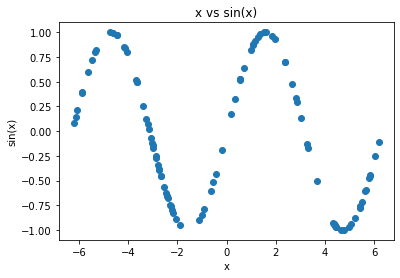

In [12]:
x = np.random.uniform(-2*np.pi,2*np.pi,(100,1))
y = np.sin(x)
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.title('x vs sin(x)')
plt.show()

In [13]:
x_test = np.random.uniform(-2*np.pi,2*np.pi,(100,1))

mu_test, sigma_test = GP_1d(x, y, x_test, 10, 0.1)
#print(mu_test.shape)
#print(sigma_test.shape)

In [14]:
test_out_1 = np.random.multivariate_normal(mu_test.reshape(len(x_test)), sigma_test, len(x_test))
#print(test_out.shape)

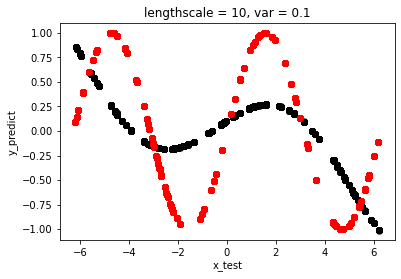

In [15]:
for i in range(len(x_test)):
    plt.scatter(x_test,test_out_1[i,:], c="black", alpha=0.5)
    plt.scatter(x, y, c = 'red')
    
plt.xlabel('x_test')
plt.ylabel('y_predict')
plt.title('lengthscale = 10, var = 0.1')

plt.show()

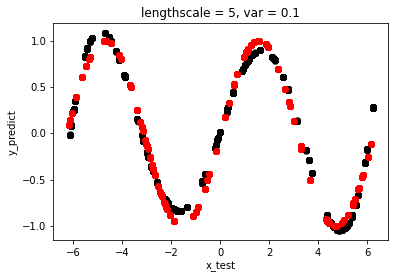

In [16]:
mu_test2, sigma_test2 = GP_1d(x, y, x_test, 5, 0.1)

test_out_2 = np.random.multivariate_normal(mu_test2.reshape(len(x_test)), sigma_test2, len(x_test))

for i in range(len(x_test)):
    plt.scatter(x_test,test_out_2[i,:], c="black", alpha=0.5)
    plt.scatter(x, y, c = 'red')
    
plt.xlabel('x_test')
plt.ylabel('y_predict')
plt.title('lengthscale = 5, var = 0.1')
plt.show()

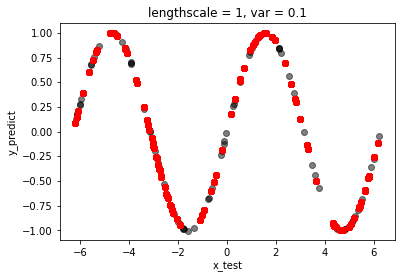

In [17]:
mu_test3, sigma_test3 = GP_1d(x, y, x_test, 1, 0.1)

#test_out3 = np.random.multivariate_normal(mu_test3.reshape(len(x_test)), sigma_test3, len(x_test))
test_out_3 = np.random.multivariate_normal(mu_test3.reshape(len(x_test)), sigma_test3)

for i in range(len(x_test)):
    #plt.scatter(x_test,test_out3[i,:], c="black", alpha=0.5)
    plt.scatter(x_test[i],test_out_3[i], c="black", alpha=0.5)
    plt.scatter(x, y, c = 'red')
    
plt.xlabel('x_test')
plt.ylabel('y_predict')
plt.title('lengthscale = 1, var = 0.1')

plt.show()

In [18]:
def RBF_nd(X1, X2, l, var):
    '''
        l = lengthscale
        var = variance (sigma^2)
        
        scipy.spatial.distance.cdist(XA, XB, metric='euclidean', *, out=None, **kwargs)
        Compute distance between each pair of the two collections of inputs.
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
        
        Kxx = | k(x1,x1)   k(x1,x2)   ....   k(x1,xn) |
              |                                       |
              | k(xn,x1)   k(xn,x2)   ....   k(xn,xn) |
    '''
    d = scipy.spatial.distance.cdist(X1, X2, 'cityblock')
    K = var * np.exp(-(d**2)/(2*(l**2)))
    return K
    
def GP(x_in, y_out, x_test, l, var, noise, prior_mean):
    #prior_mean = 0
    #noise = 1e-5
    
    Kxx = RBF_nd(x_in, x_in, l, var)

    L = np.linalg.cholesky(Kxx + noise*np.eye(x_in.shape[0])) # add noise

    alpha = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, y_out, lower=True)) # solve(a, b) --> ax = b --> x = a\b = a^-1b

    Kxxt = RBF_nd(x_in, x_test, l, var)

    Kxtxt = RBF_nd(x_test, x_test, l, var)

    mu_post = np.matmul(Kxxt.T, alpha)

    v = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, Kxxt, lower=True))
    sigma_post = Kxtxt - np.matmul(Kxxt.T, v)
    
    return mu_post, sigma_post
 
def log_like(x_in, y_out, x_test, l, var, noise):
    Kxx = RBF_nd(x_in, x_in, l, var)
    
    L = np.linalg.cholesky(Kxx + noise*np.eye(x_in.shape[0])) # add noise

    alpha = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, y_out, lower=True)) # solve(a, b) --> ax = b --> x = a\b = a^-1b

    #MLL = (-.5*train_out.T*np.inv(Kxx)*train_out) - (.5*np.log(Kxx)) - (n/2)*np.log(2*np.pi)
    
    #np.sum(np.log(np.abs(K_chol))) + np.sum(scipy.linalg.solve_triangular((y_out), K_chol)**2) - 

    temp = 0
    n = len(x_in) #num training points
    for i in range(len(L)):
        temp+=np.log(L[i][i])
    MLL = -.5*y_out.T*alpha - temp - (n/2)*np.log(2*np.pi)
    return MLL

def log_like_1d(x_in, y_out, x_test, l, var):
    Kxx = RBF_1d(x_in, x_in, l, var)
    
    L = np.linalg.cholesky(Kxx + 1e-5*np.eye(x_in.shape[0])) # add noise

    alpha = scipy.linalg.solve_triangular(L.T, scipy.linalg.solve_triangular(L, y_out, lower=True)) # solve(a, b) --> ax = b --> x = a\b = a^-1b

    #MLL = (-.5*train_out.T*np.inv(Kxx)*train_out) - (.5*np.log(Kxx)) - (n/2)*np.log(2*np.pi)
    
    #np.sum(np.log(np.abs(K_chol))) + np.sum(scipy.linalg.solve_triangular((y_out), K_chol)**2) - 

    temp = 0
    n = len(x_in) #num training points
    for i in range(len(L)):
        temp+=np.log(L[i][i])
    MLL = -.5*y_out.T*alpha - temp - (n/2)*np.log(2*np.pi)
    return MLL
    
def sum_sq_err(y_pred, y_true):
    total = 0
    for i in range(len(y_pred)):
        total+=((y_pred[i] - y_true[i])**2)
    return total

#def grad_descent():
    
def gradient_descent(loss_func, alpha_choice, max_its, params):
    g_flat, unflatten, w = flatten_func(loss_func, params) # note here the output 'w' is also flattened

    # compute the gradient function of our input function - note this is a function too
    # that - when evaluated - returns both the gradient and function evaluations (remember
    # as discussed in Chapter 3 we always ge the function evaluation 'for free' when we use
    # an Automatic Differntiator to evaluate the gradient)
    gradient = value_and_grad(g_flat)

    # run the gradient descent loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # evaluate the gradient, store current (unflattened) weights and cost function value
        cost_eval,grad_eval = gradient(w)
        weight_history.append(unflatten(w))
        cost_history.append(cost_eval)

        # take gradient descent step
        params = params - alpha*grad_eval
            
    # collect final weights
    weight_history.append(unflatten(w))
    # compute final cost function value via g itself (since we aren't computing 
    # the gradient at the final step we don't get the final cost function value 
    # via the Automatic Differentiatoor) 
    cost_history.append(g_flat(w))  
    return weight_history[-1],cost_history[-1]

#def optimize():
        
#def log_max():

def MSE(mean_out, y_true):
    total = 0
    for i in range(len(mean_out)):
        total+=((mean_out[i][0] - y_true[i])**2)
    return total

def neg_log_prob(mean_out, y_true, post_var):
    noise = 1e-5*np.eye(post_var.shape[0])
    pred_var = post_var + noise
    #print((2*np.pi*pred_var))
    return .5*np.log(2*np.pi*(np.abs(pred_var))) + ((y_true-mean_out)**2)/(2*pred_var)

In [19]:
y_true = np.sin(x_test)

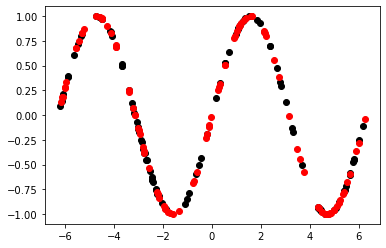

In [20]:
plt.scatter(x, y, color = 'black')
plt.scatter(x_test, y_true, color = 'red')
# plt.show()

In [21]:
print('Sum Square Errors with length scale = 10: ', sum_sq_err(test_out_1[0], y_true))
print('Sum Square Errors with length scale = 5: ', sum_sq_err(test_out_2[0], y_true))
print('Sum Square Errors with length scale = 1: ', sum_sq_err(test_out_3, y_true))
print('\n')
print('MSE with length scale = 10: ', sum_sq_err(mu_test[0], y_true))
print('MSE with length scale = 5: ', sum_sq_err(mu_test2[0], y_true))
print('MSE with length scale = 1: ', sum_sq_err(mu_test3, y_true))

Sum Square Errors with length scale = 10:  [29.00179913]
Sum Square Errors with length scale = 5:  [1.01738553]
Sum Square Errors with length scale = 1:  [0.00031755]


MSE with length scale = 10:  [0.42611088]
MSE with length scale = 5:  [0.01441176]
MSE with length scale = 1:  [1.92822728e-05]


Sum Square Errors with length scale = 5, var = 0.01:  [2.06614546]


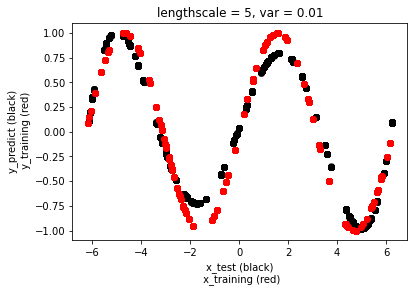

In [22]:
mu_test4, sigma_test4 = GP_1d(x, y, x_test, 5, 0.01)

test_out_4 = np.random.multivariate_normal(mu_test4.reshape(len(x_test)), sigma_test4, len(x_test))

for i in range(len(x_test)):
    plt.scatter(x_test,test_out_4[i,:], c="black", alpha=0.5)
    plt.scatter(x, y, c = 'red')
print('Sum Square Errors with length scale = 5, var = 0.01: ', sum_sq_err(test_out_4[0], y_true))

plt.xlabel('x_test (black)\n x_training (red)')
plt.ylabel('y_predict (black)\n y_training (red)')
plt.title('lengthscale = 5, var = 0.01')

plt.show()

Sum Square Errors with length scale = 10, var = 0.0001:  [40.68296217]


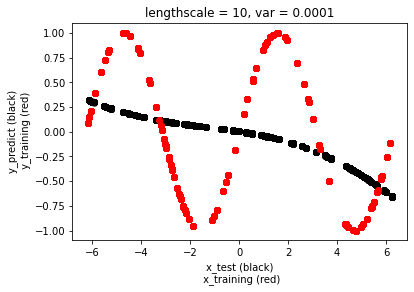

In [23]:
mu_test4, sigma_test4 = GP_1d(x, y, x_test, 10, 0.0001)

test_out_4 = np.random.multivariate_normal(mu_test4.reshape(len(x_test)), sigma_test4, len(x_test))

for i in range(len(x_test)):
    plt.scatter(x_test,test_out_4[i,:], c="black", alpha=0.5)
    plt.scatter(x, y, c = 'red')
print('Sum Square Errors with length scale = 10, var = 0.0001: ', sum_sq_err(test_out_4[0], y_true))

plt.xlabel('x_test (black)\n x_training (red)')
plt.ylabel('y_predict (black)\n y_training (red)')
plt.title('lengthscale = 10, var = 0.0001')

plt.show()

Sum Square Errors with length scale = 0.1:  [4.67723795]


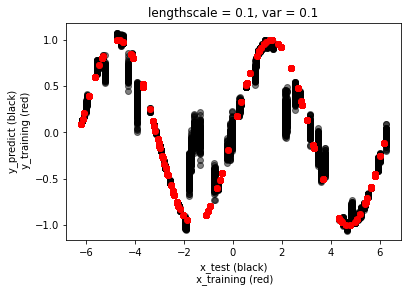

In [24]:
mu_test5, sigma_test5 = GP_1d(x, y, x_test, .1, .01)

test_out_5 = np.random.multivariate_normal(mu_test5.reshape(len(x_test)), sigma_test5, len(x_test))

for i in range(len(x_test)):
    plt.scatter(x_test,test_out_5[i,:], c="black", alpha=0.5)
    plt.scatter(x, y, c = 'red')
print('Sum Square Errors with length scale = 0.1: ', sum_sq_err(test_out_5[0], y_true))

plt.xlabel('x_test (black)\n x_training (red)')
plt.ylabel('y_predict (black)\n y_training (red)')
plt.title('lengthscale = 0.1, var = 0.1')

plt.show()

In [25]:
x_train = train_in2[0:100]
x_train = np.array(x_train)
x_test = test_in2[0:10]
x_test = np.array(x_test)
y_train = np.zeros(100)
y_true = np.zeros(10)

for i in range(100):
    y_train[i] = train_out2[i][0]
    
for i in range(10):
    y_true[i] = test_out2[i][0]

print('inputs: robot v - commanded v, robot w - commanded w, dt \n output: ∆x \n 100 test points and 10 training point \n')
    
print('length scale = 1')
    
mu, sigma = GP(x_train, y_train, x_test, 1, 0.1, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)

print('average square error = ', sum_sq_err(y_predict, y_true)/10)

LL = log_like(x_train, y_train, x_test, 1, 0.1, 1e-1)
print('log marginal likelihood', LL[0], '\n')

print('length scale = 10')

mu, sigma = GP(x_train, y_train, x_test, 10, .1, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)

print('average square error = ', sum_sq_err(y_predict, y_true)/10)

LL = log_like(x_train, y_train, x_test, 10, 0.1, 1e-1)
print('log marginal likelihood', LL[0], '\n')

print('length scale = 100')

mu, sigma = GP(x_train, y_train, x_test, 100, .1, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)

print('average square error = ', sum_sq_err(y_predict, y_true)/10)

LL = log_like(x_train, y_train, x_test, 100, 0.1, 1e-1)
print('log marginal likelihood', LL[0], '\n')

print('length scale = 1000')

mu, sigma = GP(x_train, y_train, x_test, 1000, .1, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)

print('average square error = ', sum_sq_err(y_predict, y_true)/10)

LL = log_like(x_train, y_train, x_test, 1000, 0.1, 1e-1)
print('log marginal likelihood', LL[0], '\n')

print('length scale = 10000')

mu, sigma = GP(x_train, y_train, x_test, 10000, .1, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)

print('average square error = ', sum_sq_err(y_predict, y_true)/10)

LL = log_like(x_train, y_train, x_test, 10000, 0.1, 1e-1)
print('log marginal likelihood', LL[0], '\n')

inputs: robot v - commanded v, robot w - commanded w, dt 
 output: ∆x 
 100 test points and 10 training point 

length scale = 1
average square error =  0.0024821403507291825
log marginal likelihood 20.054450217057592 

length scale = 10
average square error =  0.0006978596855591689
log marginal likelihood 20.91056682590535 

length scale = 100
average square error =  0.0008173442407665068
log marginal likelihood 20.927666157237752 

length scale = 1000
average square error =  0.0002446856179169557
log marginal likelihood 20.927839567382975 

length scale = 10000
average square error =  0.0006404300875035071
log marginal likelihood 20.92784130173112 



<ipython-input-25-eb56f29030c0>:20: RuntimeWarning: covariance is not positive-semidefinite.
  y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)
<ipython-input-25-eb56f29030c0>:31: RuntimeWarning: covariance is not positive-semidefinite.
  y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)
<ipython-input-25-eb56f29030c0>:42: RuntimeWarning: covariance is not positive-semidefinite.
  y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)


In [26]:
x_train = train_in2[0:1000]
x_train = np.array(x_train)
x_test = test_in2[0:100]
x_test = np.array(x_test)
y_train = np.zeros(1000)
y_true = np.zeros(100)

for i in range(1000):
    y_train[i] = train_out2[i][0]
    
for i in range(100):
    y_true[i] = test_out2[i][0]

mu, sigma = GP(x_train, y_train, x_test, 100, .1, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)

print('1000 training points, 100 testing points')
print('length scale = 100')
print('average square error = ', sum_sq_err(y_predict, y_true)/100)

LL = log_like(x_train, y_train, x_test, 100, 0.1, 1e-1)
print('log marginal likelihood', LL[0], '\n')

1000 training points, 100 testing points
length scale = 100
average square error =  0.00030292245647556965


<ipython-input-26-4d25ee14206b>:16: RuntimeWarning: covariance is not positive-semidefinite.
  y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)


log marginal likelihood 228.8964549583484 



In [27]:
x_train = train_in2[0:10000]
x_train = np.array(x_train)
x_test = test_in2[0:1000]
x_test = np.array(x_test)
y_train = np.zeros(10000)
y_true = np.zeros(1000)

for i in range(10000):
    y_train[i] = train_out2[i][0]
    
for i in range(1000):
    y_true[i] = test_out2[i][0]

mu, sigma = GP(x_train, y_train, x_test, 100, .1, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)

print('10000 training points, 1000 testing points')
print('length scale = 100')
print('average square error = ', sum_sq_err(y_predict, y_true)/1000)

LL = log_like(x_train, y_train, x_test, 100, 0.1, 1e-1)
print('log marginal likelihood', LL[0], '\n')

<ipython-input-27-dd8292d85be1>:16: RuntimeWarning: covariance is not positive-semidefinite.
  y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)


10000 training points, 1000 testing points
length scale = 100
average square error =  0.00015036415364126797
log marginal likelihood 2318.56571694551 



In [28]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, DotProduct, RBF
import matplotlib.pyplot as plt
import numpy as np

# Random seeds
np.random.seed(seed=0)  # Set seed for NumPy
random_state = 0


# Create kernel and define GPR
kernel = RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=random_state)

# Fit GPR model
gpr.fit(x_train[0:100], y_train[0:100])
 
# Predict mean
y_hat, y_sigma = gpr.predict(x_test[0:10], return_std=True)

print(gpr.get_params)
print(gpr.log_marginal_likelihood_value_)
print(gpr.kernel_)

<bound method BaseEstimator.get_params of GaussianProcessRegressor(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         random_state=0)>
464.47284290058104
RBF(length_scale=1e+05) + WhiteKernel(noise_level=1e-05)


/Users/mackenziegray/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/mackenziegray/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


In [29]:
# Random seeds
np.random.seed(seed=0)  # Set seed for NumPy
random_state = 0


# Create kernel and define GPR
kernel = RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=random_state)

# Fit GPR model
gpr.fit(x_train[0:1000], y_train[0:1000])
 
# Predict mean
y_hat, y_sigma = gpr.predict(x_test[0:100], return_std=True)


#print(gpr.get_params)
print(gpr.log_marginal_likelihood_value_)
print(gpr.kernel_)

4754.386652043086
RBF(length_scale=21.6) + WhiteKernel(noise_level=1e-05)


/Users/mackenziegray/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


In [30]:
mu, sigma = GP(x_train[0:1000], y_train[0:1000], x_test[0:100], 21.6, .00001, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(100,), sigma)
print('1000 training points, 100 test points \n optimal length scale = 21.6, var = 0.00001')
print('average square error = ', sum_sq_err(y_predict, y_true)/100)

LL = log_like(x_train, y_train, x_test, 21.6, 0.00001, 1e-1)
print('log marginal likelihood', LL[0], '\n')

1000 training points, 100 test points 
 optimal length scale = 21.6, var = 0.00001
average square error =  3.0364771437471675e-05
log marginal likelihood 2323.1935026559586 



In [31]:
std1 = np.sqrt(np.diag(sigma))

lower = mu-std1
upper = mu+std1

L = []
U = []

for i in range(100):
    #L.append(lower[i][i])
    #U.append(upper[i][i])
    L.append(lower[i])
    U.append(upper[i])

Text(0.5, 1.0, 'blue = true output, black = predicted by sklearn GPR, \n red = mean predicted by my algorithm, \n green = +/- standard deviation confidence bounds')

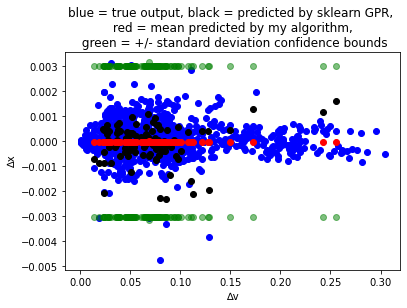

In [32]:
plt.scatter(np.array(x_test).T[0][0:1000], y_true[0:1000], color = 'blue')
plt.scatter(np.array(x_test).T[0][0:100], y_hat, color = 'black')
plt.scatter(np.array(x_test).T[0][0:100], mu, color = 'red')
plt.xlabel('∆v')
plt.ylabel('∆x')

plt.scatter(np.array(x_test).T[0][0:100], L, alpha=0.5, color = 'green')
plt.scatter(np.array(x_test).T[0][0:100], U, alpha=0.5, color = 'green')
plt.title('blue = true output, black = predicted by sklearn GPR, \n red = mean predicted by my algorithm, \n green = +/- standard deviation confidence bounds')

plt.show()

Text(0.5, 1.0, 'blue = true output, black = predicted by sklearn GPR, \n red = mean predicted by my algorithm, \n green = +/- standard deviation confidence bounds')

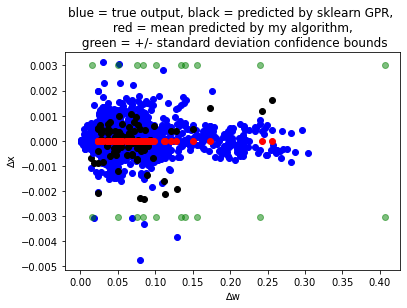

In [33]:
'''
for i in range(len(y_hat)):
    if i != 14:
        plt.scatter(np.array(x_test)[i][1], y_true[i], color = 'blue')
        plt.scatter(np.array(x_test)[i][1],y_hat[i], color = 'black')
        plt.scatter(np.array(x_test)[i][1], mu[i], color = 'red')
'''
plt.scatter(np.array(x_test).T[0][0:15], y_true[0:15], color = 'blue')
plt.scatter(np.array(x_test).T[0][0:15], y_hat[0:15], color = 'black')
plt.scatter(np.array(x_test).T[0][0:15], mu[0:15], color = 'red')
plt.scatter(np.array(x_test).T[0][16:1000], y_true[16:1000], color = 'blue')
plt.scatter(np.array(x_test).T[0][16:100], y_hat[16:100], color = 'black')
plt.scatter(np.array(x_test).T[0][16:100], mu[16:100], color = 'red')
plt.xlabel('∆w')
plt.ylabel('∆x')

plt.scatter(np.array(x_test).T[1][0:10], L[0:10], alpha=0.5, color = 'green')
plt.scatter(np.array(x_test).T[1][0:10], U[0:10], alpha=0.5, color = 'green')

#plt.plot(np.array(x_test).T[1][16:100], L[16:100], alpha=0.5, color = 'green')
#plt.plot(np.array(x_test).T[1][16:100], U[16:100], alpha=0.5, color = 'green')
plt.title('blue = true output, black = predicted by sklearn GPR, \n red = mean predicted by my algorithm, \n green = +/- standard deviation confidence bounds')

plt.show()

Text(0.5, 1.0, 'blue = true output, black = predicted by sklearn GPR, \n red = mean predicted by my algorithm, \n green = +/- standard deviation confidence bounds')

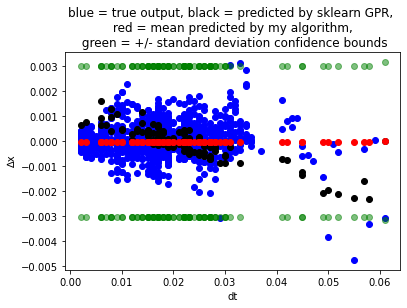

In [34]:
plt.scatter(np.array(x_test).T[2], y_true, color = 'blue')
plt.scatter(np.array(x_test).T[2][0:100], y_hat, color = 'black')
plt.scatter(np.array(x_test).T[2][0:100], mu, color = 'red')

plt.xlabel('dt')
plt.ylabel('∆x')
plt.scatter(np.array(x_test).T[2][0:100], L, alpha=0.5, color = 'green')
plt.scatter(np.array(x_test).T[2][0:100], U, alpha=0.5, color = 'green')
plt.title('blue = true output, black = predicted by sklearn GPR, \n red = mean predicted by my algorithm, \n green = +/- standard deviation confidence bounds')

plt.show()

In [35]:
train_in3 = []
train_out3 = []

test_in3 = []
test_out3 = []

val_in3 = []
val_out3 = []

ind = np.linspace(0, len(align), 10000)
ind_count = 0
index = 0

for i in range(2000):
    dt_in = 0
    dt_out = 0
    v_in = 0
    w_in = 0
    
    x_in = align[index+25][0][1] - align[index][0][1]
    y_in = align[index+25][0][2] - align[index][0][2]
    theta_in = align[index+25][0][3] - align[index][0][3]
    
    for j in range(25):
        dt_in += align[index+1][0][0] - align[index][0][0] #sum 25 timesteps
        dt_out += align[index+2][0][0] - align[index+1][0][0] # (t+1) - (t)
        
        v_in += align[index+1][1][1] - align[index][1][1]
        w_in += align[index+1][1][2] - align[index][1][2]

        index+=1
        
    v_in = v_in/25 #average of 25 timesteps
    w_in = w_in/25
    
    v = np.sqrt(((x_in/dt_in)**2)+((y_in/dt_in)**2))
    w = theta_in/dt_in

    del_v = np.abs(v - v_in)
    del_w = np.abs(w - w_in)

    x_out = align[index+25][0][1] - align[index][0][1]
    y_out = align[index+25][0][2] - align[index][0][2]
    theta_out = align[index+25][0][3] - align[index][0][3]
    
    if (i == int(ind[ind_count]) and ind_count%2 ==0):
        test_in3.append([del_v, del_w, dt_out])
        test_out3.append([x_out, y_out, theta_out])
        ind_count+=1
    elif (i == int(ind[ind_count]) and ind_count%2 ==1):
        val_in3.append([del_v, del_w, dt_out])
        val_out3.append([x_out, y_out, theta_out])
        ind_count+=1
    else:
        train_in3.append([del_v, del_w, dt_out])
        train_out3.append([x_out, y_out, theta_out])

In [36]:
x_train3 = np.array(train_in3)
x_test3 = np.array(test_in3)
y_train3 = np.zeros(len(x_train3))
y_true3 = np.zeros(len(x_test3))

for i in range(len(x_train3)):
    y_train3[i] = train_out3[i][0]
    
for i in range(len(x_test3)):
    y_true3[i] = test_out3[i][0]

In [37]:
gpr = GaussianProcessRegressor(kernel=kernel, random_state=random_state)

# Fit GPR model
gpr.fit(x_train3, y_train3)
 
# Predict mean
y_hat3, y_sigma3 = gpr.predict(x_test3, return_std=True)


#print(gpr.get_params)
print(gpr.log_marginal_likelihood_value_)
print(gpr.kernel_)

4980.831669568006
RBF(length_scale=17.3) + WhiteKernel(noise_level=0.000207)


Text(0.5, 0, '∆x')

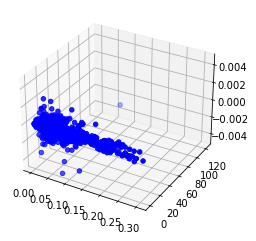

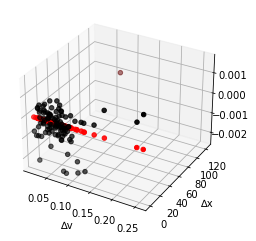

In [38]:
# Plot Figures
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')


#ax.scatter(train_x_inputs[0:, 0], train_x_inputs[0:, 2], zs=train_x_output, s=1)
#ax.scatter(test_x_inputs[0:, 0], test_x_inputs[0:, 2], c="r", zs=test_x_predic, zorder=5)
#plt.xlabel("v")
#plt.ylabel("th")
#plt.title("LWR for Change in x")
#plt.legend(["Training Data", "Testing Data"])
#ax.set_zlabel("dx")
ax.set_zlim(-.005, .005)

ax.scatter(np.array(x_test).T[0][0:1000], np.array(x_test).T[1][0:1000], zs = y_true[0:1000], color = 'blue')
ax2.scatter(np.array(x_test).T[0][0:100], np.array(x_test).T[1][0:100], zs = y_hat, color = 'black')
ax2.scatter(np.array(x_test).T[0][0:100],np.array(x_test).T[1][0:100],  zs = mu, color = 'red')

plt.xlabel('∆v')
plt.ylabel('∆x')

In [39]:
trans = []
rot = []
stop = []

for i in range(len(align)-1):
    if align[i][1][1] == 0 and align[i][1][2]!=0: # v=0, w!=0
        trans.append([align[i+1][0][1] - align[i][0][1], align[i+1][0][2] - align[i][0][2], align[i+1][0][3] - align[i][0][3]])
    elif align[i][1][2] ==0 and align[i][1][1]!=0: # w=0, v!=0
        rot.append([align[i+1][0][1] - align[i][0][1], align[i+1][0][2] - align[i][0][2], align[i+1][0][3] - align[i][0][3]])
    elif align[i][1][1] ==0 and align[i][1][2]==0: # v=0, w=0
        stop.append([align[i+1][0][1] - align[i][0][1], align[i+1][0][2] - align[i][0][2], align[i+1][0][3] - align[i][0][3]])

Text(0.5, 1.0, 'Change in heading angle with zero commanded rotational velocity')

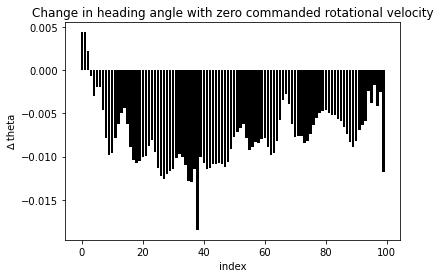

In [40]:
x = np.linspace(0, len(trans)-1, len(trans))
# print(len(x), len(trans))
for i in range(100):
    plt.bar(x[i], trans[i][2], color='black')
plt.xlabel('index')
plt.ylabel('∆ theta')
plt.title('Change in heading angle with zero commanded rotational velocity')

plt.show()

Text(0.5, 1.0, 'Change in position with zero commanded translational velocity')

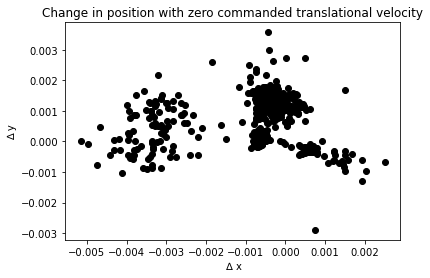

In [41]:
for i in range(500):
    plt.scatter(rot[i][0], rot[i][1], color='black')
plt.xlabel(' ∆ x')
plt.ylabel('∆ y')
plt.title('Change in position with zero commanded translational velocity')

plt.show()

Text(0.5, 1.0, 'Change in position with zero commanded rotational and translational velocities')

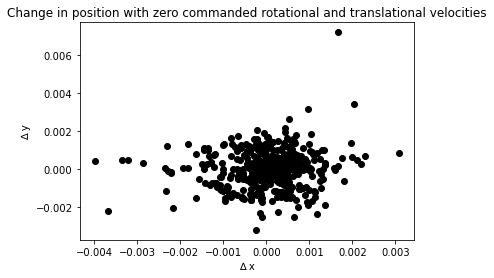

In [42]:
for i in range(len(stop)):
    plt.scatter(stop[i][0], stop[i][1], color='black')
plt.xlabel('∆ x')
plt.ylabel('∆ y')
plt.title('Change in position with zero commanded rotational and translational velocities')

plt.show()

Text(0.5, 1.0, 'Change in heading angle with zero commanded rotational and translational velocities')

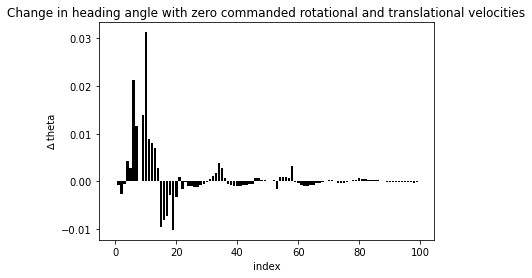

In [43]:
for i in range(100):
    plt.bar(x[i], stop[i][2], color='black')
plt.xlabel('index')
plt.ylabel('∆ theta')
plt.title('Change in heading angle with zero commanded rotational and translational velocities')

plt.show()

Text(0.5, 1.0, 'Change in y with zero commanded rotational and translational velocities')

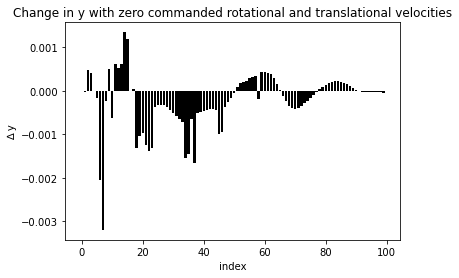

In [44]:
for i in range(100):
    plt.bar(x[i], stop[i][1], color='black')
plt.xlabel('index')
plt.ylabel('∆ y')
plt.title('Change in y with zero commanded rotational and translational velocities')

plt.show()

Text(0.5, 1.0, 'Change in x with zero commanded rotational and translational velocities')

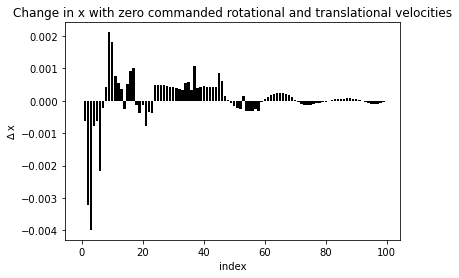

In [45]:
for i in range(100):
    plt.bar(x[i], stop[i][0], color='black')
plt.xlabel('index')
plt.ylabel('∆ x')
plt.title('Change in x with zero commanded rotational and translational velocities')

plt.show()

In [46]:
dead_reck = []
x = align[0][0][1]
y = align[0][0][2]
theta = align[0][0][3]

for i in range(len(align)-1):
    trans = align[i][1][1]
    rot = align[i][1][2]
    dt = align[i+1][0][0] - align[i][0][0]
    
    if(rot == 0):
        x_next = x + (trans*np.cos(theta)*dt)
        y_next = y + (trans*np.sin(theta)*dt)
        theta_next = theta + (rot*dt)
    else:
        #mathematical derivation given in Prob Robotics 5.3.3, eqns 5.9, pg. 127
        x_next = x + ( (-trans/rot)*np.sin(theta) + (trans/rot)*np.sin(theta + (rot*dt)) )
        y_next = y + ( (trans/rot)*np.cos(theta) - (trans/rot)*np.cos(theta + (rot*dt)) )
        theta_next = theta + (rot*dt)
        
    if theta_next > 2*np.pi:
        theta_next-=2*np.pi
    
    if theta_next > np.pi and theta_next < 2*np.pi:
        theta_next = (-2*np.pi)+theta_next

    next_state = [x_next, y_next, theta_next]
    dead_reck.append(next_state)
    
    x = x_next
    y = y_next
    theta = theta_next

In [47]:
x_err_each = []
y_err_each = []
theta_err_each = []

for i in range(len(align)-1):
    x = (align[i][0][1])
    y = (align[i][0][2])
    theta = (align[i][0][3])
    
    trans = align[i][1][1]
    rot = align[i][1][2]
    dt = align[i+1][0][0] - align[i][0][0]
    
    if(rot == 0):
        x_next = x + (trans*np.cos(theta)*dt)
        y_next = y + (trans*np.sin(theta)*dt)
        theta_next = theta + (rot*dt)
    else:
        #mathematical derivation given in Prob Robotics 5.3.3, eqns 5.9, pg. 127
        x_next = x + ( (-trans/rot)*np.sin(theta) + (trans/rot)*np.sin(theta + (rot*dt)) )
        y_next = y + ( (trans/rot)*np.cos(theta) - (trans/rot)*np.cos(theta + (rot*dt)) )
        theta_next = theta + (rot*dt)
        
    if theta_next > 2*np.pi:
        theta_next-=2*np.pi
    
    if theta_next > np.pi and theta_next < 2*np.pi:
        theta_next = (-2*np.pi)+theta_next

    x_err_each.append(np.abs(x_next - align[i+1][0][1]))
    y_err_each.append(np.abs(y_next - align[i+1][0][2]))
    theta_err_each.append(np.abs(theta_next - align[i+1][0][3]))

Text(0, 0.5, 'theta error')

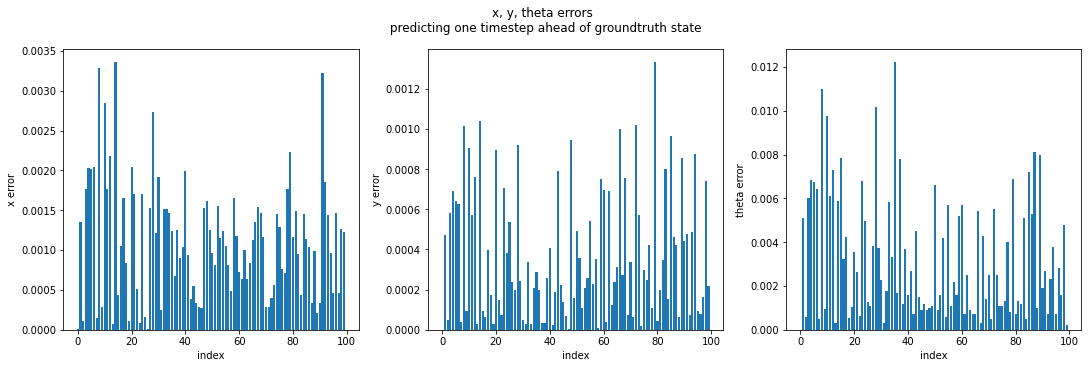

In [48]:
x = np.linspace(0, 99, 100)
y = x_err_each[0:100]

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(15,5))

fig.suptitle('x, y, theta errors \n predicting one timestep ahead of groundtruth state')

ax1.bar(x,y)
ax1.set_xlabel('index')
ax1.set_ylabel('x error')

y = y_err_each[0:100]
ax2.bar(x,y)
ax2.set_xlabel('index')
ax2.set_ylabel('y error')

y = theta_err_each[0:100]
ax3.bar(x,y)
ax3.set_xlabel('index')
ax3.set_ylabel('theta error')

plt.show()

Text(0, 0.5, 'theta error')

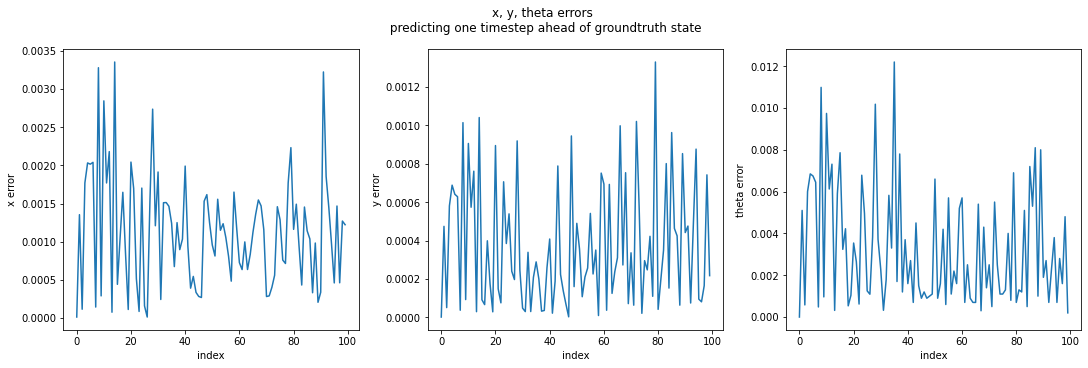

In [49]:
x = np.linspace(0, 99, 100)
y = x_err_each[0:100]

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(15,5))

fig.suptitle('x, y, theta errors \n predicting one timestep ahead of groundtruth state')

ax1.plot(x,y)
ax1.set_xlabel('index')
ax1.set_ylabel('x error')

y = y_err_each[0:100]
ax2.plot(x,y)
ax2.set_xlabel('index')
ax2.set_ylabel('y error')

y = theta_err_each[0:100]
ax3.plot(x,y)
ax3.set_xlabel('index')
ax3.set_ylabel('theta error')

plt.show()

Text(0, 0.5, 'theta error')

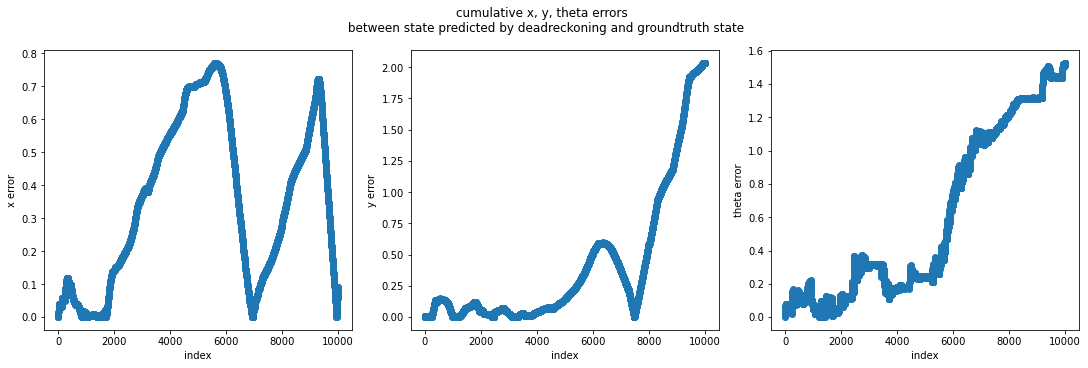

In [50]:
x_err = []
y_err = []
theta_err = []

for i in range(10000):
    x_err.append(np.abs(dead_reck[i][0] - align[i][0][1]))
    y_err.append(np.abs(dead_reck[i][1] - align[i][0][2]))
    temp = np.abs(dead_reck[i][2] - align[i][0][3])
    if temp>np.pi:
        theta_err.append(np.abs(temp - 2*np.pi))
    else:
        theta_err.append(np.abs(dead_reck[i][2] - align[i][0][3]))

x = np.linspace(0, 9999, 10000)
y = x_err[0:10000]
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(15,5))
fig.suptitle('cumulative x, y, theta errors \n between state predicted by deadreckoning and groundtruth state')

ax1.scatter(x,y)
ax1.set_xlabel('index')
ax1.set_ylabel('x error')

y = y_err[0:10000]
ax2.scatter(x,y)
ax2.set_xlabel('index')
ax2.set_ylabel('y error')

y = theta_err[0:10000]
ax3.scatter(x,y)
ax3.set_xlabel('index')
ax3.set_ylabel('theta error')

plt.show()

Text(0.5, 1.0, 'Deadreckoning (red) vs Groundtruth (black)')

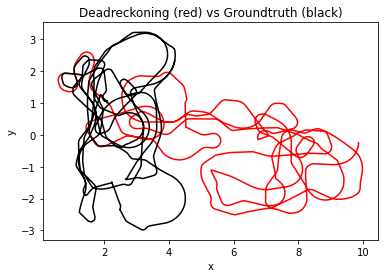

In [51]:
drx = []
dry = []
gtx = []
gty = []

for i in range(len(dead_reck)):
    drx.append(dead_reck[i][0])
    dry.append(dead_reck[i][1])
    
for i in range(len(align)):
    gtx.append(align[i][0][1])
    gty.append(align[i][0][2])

plt.plot(drx, dry, color = 'red')
plt.plot(gtx, gty, color = 'black')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Deadreckoning (red) vs Groundtruth (black)')

plt.show()

In [52]:
x_train_all = train_in2
x_train_all = np.array(x_train_all)
x_test_all = test_in2
x_test_all = np.array(x_test_all)
y_train_all = np.zeros(len(x_train_all))
y_true_all = np.zeros(len(x_test_all))

for i in range(len(train_out2)):
    y_train_all[i] = train_out2[i][0]
    
for i in range(len(test_out2)):
    y_true_all[i] = test_out2[i][0]

In [53]:
'''mu, sigma = GP(x_train_all[0:50000], y_train_all[0:50000], x_test_all, 21.6, .00001, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(len(mu),), sigma)
print('all training points, all test points \n optimal length scale = 21.6, var = 0.00001')
print('average square error = ', sum_sq_err(y_predict, y_true)/len(x_test_all))

LL = log_like(x_train_all[0:50000], y_train_all[0:50000], x_test_all, 21.6, 0.00001, 1e-1)
print('log marginal likelihood', LL[0], '\n')
'''

"mu, sigma = GP(x_train_all[0:50000], y_train_all[0:50000], x_test_all, 21.6, .00001, 1e-1, 0)\n\ny_predict = np.random.multivariate_normal(mu.reshape(len(mu),), sigma)\nprint('all training points, all test points \n optimal length scale = 21.6, var = 0.00001')\nprint('average square error = ', sum_sq_err(y_predict, y_true)/len(x_test_all))\n\nLL = log_like(x_train_all[0:50000], y_train_all[0:50000], x_test_all, 21.6, 0.00001, 1e-1)\nprint('log marginal likelihood', LL[0], '\n')\n"

In [100]:
x_train = train_in2[0:10000]
x_train = np.array(x_train)
x_test = test_in2[0:5000]
x_test = np.array(x_test)
y_train = np.zeros(10000)
y_true = np.zeros(5000)

for i in range(10000):
    y_train[i] = train_out2[i][0]
    
for i in range(5000):
    y_true[i] = test_out2[i][0]

mu, sigma = GP(x_train, y_train, x_test, 10, .1, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)

print('10000 training points, 5000 testing points')
print('length scale = 10')
print('average square error = ', sum_sq_err(y_predict, y_true)/5000)

LL = log_like(x_train, y_train, x_test, 10, 0.1, 1e-1)
print('log marginal likelihood', LL[0], '\n')

<ipython-input-100-328a40304f48>:16: RuntimeWarning: covariance is not positive-semidefinite.
  y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)


10000 training points, 5000 testing points
length scale = 10
average square error =  0.00012702868458445288
log marginal likelihood 2317.539438615844 



In [56]:
x_train = train_in2[10000:20000]
x_train = np.array(x_train)
x_test = test_in2[0:5000]
x_test = np.array(x_test)
y_train = np.zeros(10000)
y_true = np.zeros(5000)

for i in range(10000):
    y_train[i] = train_out2[i][0]
    
for i in range(5000):
    y_true[i] = test_out2[i][0]

mu, sigma = GP(x_train, y_train, x_test, 10, .1, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)

print('10000 training points, 5000 testing points')
print('length scale = 10')
print('average square error = ', sum_sq_err(y_predict, y_true)/5000)

LL = log_like(x_train, y_train, x_test, 10, 0.1, 1e-1)
print('log marginal likelihood', LL[0], '\n')

<ipython-input-56-d149790925d0>:16: RuntimeWarning: covariance is not positive-semidefinite.
  y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)


10000 training points, 1000 testing points
length scale = 100
average square error =  0.00022451767737037475
log marginal likelihood 2317.938642050689 



In [58]:
x_train = train_in2[20000:30000]
x_train = np.array(x_train)
x_test = test_in2[0:5000]
x_test = np.array(x_test)
y_train = np.zeros(10000)
y_true = np.zeros(5000)

for i in range(10000):
    y_train[i] = train_out2[i][0]
    
for i in range(5000):
    y_true[i] = test_out2[i][0]

mu, sigma = GP(x_train, y_train, x_test, 10, .1, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)

print('10000 training points, 5000 testing points')
print('length scale = 10')
print('average square error = ', sum_sq_err(y_predict, y_true)/5000)

LL = log_like(x_train, y_train, x_test, 10, 0.1, 1e-1)
print('log marginal likelihood', LL[0], '\n')

<ipython-input-58-d58cc9fd75ed>:16: RuntimeWarning: covariance is not positive-semidefinite.
  y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)


10000 training points, 5000 testing points
length scale = 10
average square error =  6.521480227315256e-05
log marginal likelihood 2317.191066162708 



In [59]:
x_train = train_in2[30000:40000]
x_train = np.array(x_train)
x_test = test_in2[0:5000]
x_test = np.array(x_test)
y_train = np.zeros(10000)
y_true = np.zeros(5000)

for i in range(10000):
    y_train[i] = train_out2[i][0]
    
for i in range(5000):
    y_true[i] = test_out2[i][0]

mu, sigma = GP(x_train, y_train, x_test, 10, .1, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)

print('10000 training points, 5000 testing points')
print('length scale = 10')
print('average square error = ', sum_sq_err(y_predict, y_true)/5000)

LL = log_like(x_train, y_train, x_test, 10, 0.1, 1e-1)
print('log marginal likelihood', LL[0], '\n')

<ipython-input-59-766b2ebb37eb>:16: RuntimeWarning: covariance is not positive-semidefinite.
  y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)


10000 training points, 5000 testing points
length scale = 10
average square error =  7.135577715863586e-05
log marginal likelihood 2317.9405505893374 



In [60]:
x_train = train_in2[40000:50000]
x_train = np.array(x_train)
x_test = test_in2[0:5000]
x_test = np.array(x_test)
y_train = np.zeros(10000)
y_true = np.zeros(5000)

for i in range(10000):
    y_train[i] = train_out2[i][0]
    
for i in range(5000):
    y_true[i] = test_out2[i][0]

mu, sigma = GP(x_train, y_train, x_test, 10, .1, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)

print('10000 training points, 5000 testing points')
print('length scale = 10')
print('average square error = ', sum_sq_err(y_predict, y_true)/5000)

LL = log_like(x_train, y_train, x_test, 10, 0.1, 1e-1)
print('log marginal likelihood', LL[0], '\n')

<ipython-input-60-fad041409abe>:16: RuntimeWarning: covariance is not positive-semidefinite.
  y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)


10000 training points, 5000 testing points
length scale = 10
average square error =  6.682380713813254e-05
log marginal likelihood 2317.9046605135427 



In [62]:
x_train = train_in2[50000:60000]
x_train = np.array(x_train)
x_test = test_in2[0:5000]
x_test = np.array(x_test)
y_train = np.zeros(10000)
y_true = np.zeros(5000)

for i in range(10000):
    y_train[i] = train_out2[i][0]
    
for i in range(5000):
    y_true[i] = test_out2[i][0]

mu, sigma = GP(x_train, y_train, x_test, 10, .1, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)

print('10000 training points, 5000 testing points')
print('length scale = 10')
print('average square error = ', sum_sq_err(y_predict, y_true)/5000)

LL = log_like(x_train, y_train, x_test, 10, 0.1, 1e-1)
print('log marginal likelihood', LL[0], '\n')

<ipython-input-62-8059554f8348>:16: RuntimeWarning: covariance is not positive-semidefinite.
  y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)


10000 training points, 5000 testing points
length scale = 10
average square error =  0.00011202531990242685
log marginal likelihood 2317.570933104653 



In [63]:
x_train = train_in2[60000:70000]
x_train = np.array(x_train)
x_test = test_in2[0:5000]
x_test = np.array(x_test)
y_train = np.zeros(10000)
y_true = np.zeros(5000)

for i in range(10000):
    y_train[i] = train_out2[i][0]
    
for i in range(5000):
    y_true[i] = test_out2[i][0]

mu, sigma = GP(x_train, y_train, x_test, 10, .1, 1e-1, 0)

y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)

print('10000 training points, 5000 testing points')
print('length scale = 10')
print('average square error = ', sum_sq_err(y_predict, y_true)/5000)

LL = log_like(x_train, y_train, x_test, 10, 0.1, 1e-1)
print('log marginal likelihood', LL[0], '\n')

<ipython-input-63-5825838e0788>:16: RuntimeWarning: covariance is not positive-semidefinite.
  y_predict = np.random.multivariate_normal(mu.reshape(len(x_test)), sigma)


10000 training points, 5000 testing points
length scale = 10
average square error =  0.00020031184727179458
log marginal likelihood 2313.887461043276 



Text(0.5, 1.0, 'Deadreckoning (red) vs Groundtruth (black)')

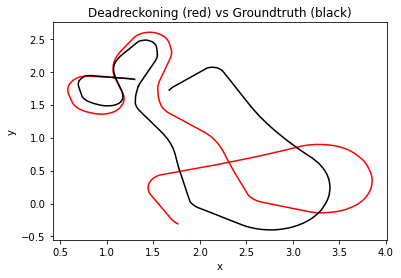

In [93]:
plt.plot(np.array(dead_reck).T[0][0:10000], np.array(dead_reck).T[1][0:10000], color = 'red')

gtx = []
gty = []
    
for i in range(10000):
    gtx.append(align[i][0][1])
    gty.append(align[i][0][2])

plt.plot(gtx, gty, color = 'black')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Deadreckoning (red) vs Groundtruth (black)')

plt.show()

Text(0.5, 1.0, 'Deadreckoning (red) vs Groundtruth (black)')

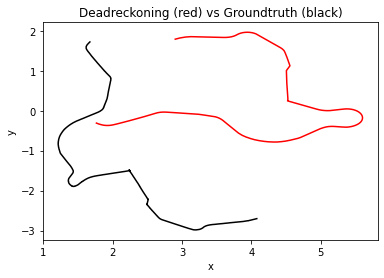

In [94]:
plt.plot(np.array(dead_reck).T[0][10000:20000], np.array(dead_reck).T[1][10000:20000], color = 'red')

gtx = []
gty = []
    
for i in range(10000):
    gtx.append(align[i+10000][0][1])
    gty.append(align[i+10000][0][2])

plt.plot(gtx, gty, color = 'black')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Deadreckoning (red) vs Groundtruth (black)')

plt.show()

Text(0.5, 1.0, 'Deadreckoning (red) vs Groundtruth (black)')

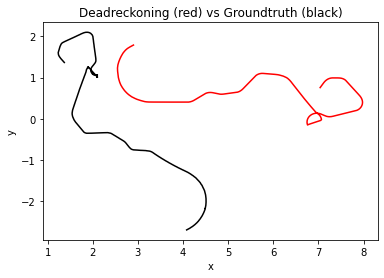

In [95]:
plt.plot(np.array(dead_reck).T[0][20000:30000], np.array(dead_reck).T[1][20000:30000], color = 'red')

gtx = []
gty = []
    
for i in range(10000):
    gtx.append(align[i+20000][0][1])
    gty.append(align[i+20000][0][2])

plt.plot(gtx, gty, color = 'black')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Deadreckoning (red) vs Groundtruth (black)')

plt.show()

Text(0.5, 1.0, 'Deadreckoning (red) vs Groundtruth (black)')

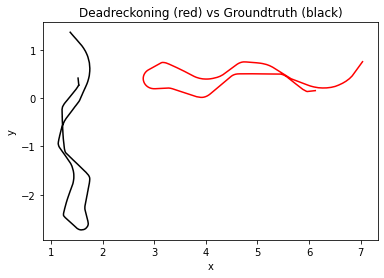

In [96]:
plt.plot(np.array(dead_reck).T[0][30000:40000], np.array(dead_reck).T[1][30000:40000], color = 'red')

gtx = []
gty = []
    
for i in range(10000):
    gtx.append(align[i+30000][0][1])
    gty.append(align[i+30000][0][2])

plt.plot(gtx, gty, color = 'black')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Deadreckoning (red) vs Groundtruth (black)')

plt.show()

Text(0.5, 1.0, 'Deadreckoning (red) vs Groundtruth (black)')

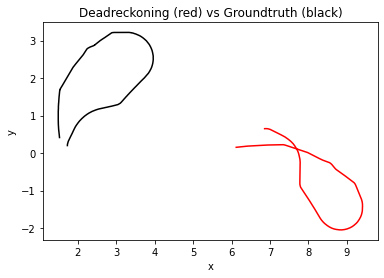

In [97]:
plt.plot(np.array(dead_reck).T[0][40000:50000], np.array(dead_reck).T[1][40000:50000], color = 'red')

gtx = []
gty = []
    
for i in range(10000):
    gtx.append(align[i+40000][0][1])
    gty.append(align[i+40000][0][2])

plt.plot(gtx, gty, color = 'black')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Deadreckoning (red) vs Groundtruth (black)')

plt.show()

Text(0.5, 1.0, 'Deadreckoning (red) vs Groundtruth (black)')

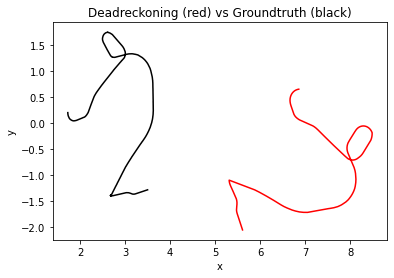

In [98]:
plt.plot(np.array(dead_reck).T[0][50000:60000], np.array(dead_reck).T[1][50000:60000], color = 'red')

gtx = []
gty = []
    
for i in range(10000):
    gtx.append(align[i+50000][0][1])
    gty.append(align[i+50000][0][2])

plt.plot(gtx, gty, color = 'black')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Deadreckoning (red) vs Groundtruth (black)')

plt.show()

Text(0.5, 1.0, 'Deadreckoning (red) vs Groundtruth (black)')

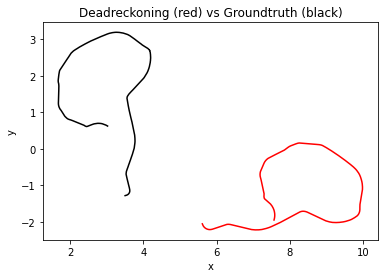

In [99]:
plt.plot(np.array(dead_reck).T[0][60000:70000], np.array(dead_reck).T[1][60000:70000], color = 'red')

gtx = []
gty = []
    
for i in range(10000):
    gtx.append(align[i+60000][0][1])
    gty.append(align[i+60000][0][2])

plt.plot(gtx, gty, color = 'black')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Deadreckoning (red) vs Groundtruth (black)')

plt.show()